# Metrics

In [2]:
!pip install pyloudnorm torchmetrics

In [3]:
!pip install librosa

In [4]:
path_to_dataset = 'https://www.openslr.org/resources/12/dev-clean.tar.gz'

In [5]:
!pip install matplotlib

In [6]:
import os
import glob
from glob import glob

import numpy as np

import random

import librosa
import soundfile as sf
import pyloudnorm as pyln
import matplotlib.pyplot as plt

import torch
from torchmetrics.audio import SignalDistortionRatio, ScaleInvariantSignalDistortionRatio
from IPython import display

from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings("ignore")

In [7]:
!pip install torchaudio

In [8]:
!pip install speechbrain

In [9]:
!pip install pandas

In [10]:
!pip install wandb

In [11]:
!pip install torch_audiomentations

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
from hw_ss.datasets.librispeech_dataset import LibrispeechDataset
from hw_ss.utils.parse_config import ConfigParser
from hw_ss.utils.object_loading import get_dataloaders
import json 

config = ConfigParser(json.load(open('hw_ss/configs/one_batch_test.json')))

dataset = get_dataloaders(config)


torchvision is not available - cannot save figures


In [1]:
for item in dataset['train']:
    print(item['audio_path'])
    break

NameError: name 'dataset' is not defined

In [14]:
def snr(est, target):
    return 20 * np.log10(np.linalg.norm(target) / (np.linalg.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / np.linalg.norm(target)**2
    return 20 * np.log10(np.linalg.norm(alpha * target) / (np.linalg.norm(alpha * target - est) + 1e-6) + 1e-6)

In [15]:
target, _ = sf.read('/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/3752/4944/3752-4944-0069.flac')
noise, _ = sf.read('/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/84/121123/84-121123-0016.flac')

meter = pyln.Meter(16000) # create BS.1770 meter

louds = meter.integrated_loudness(noise)
noise = pyln.normalize.loudness(noise, louds, -29)

In [17]:
print(length)

134560


In [16]:
length = min(len(target), len(noise))

target = target[:length]
noise = noise[:length]
s1 = target + noise
display.display(display.Audio(s1, rate=16000))

#Compute SNR

snr_val = snr(s1, target)
print(snr_val)

10.416317342394482


In [ ]:
s2 = (target + noise) * 10
display.display(display.Audio(s2, rate=16000))

snr_val = snr(s2, target)
print(snr_val)

-19.534936991485456


In [ ]:
s1.shape, target.shape

((134560,), (134560,))

In [ ]:
sdr = SignalDistortionRatio()

print("SDR for s1:", sdr(torch.from_numpy(s1), torch.from_numpy(target)).item())
print("SDR for s2:", sdr(torch.from_numpy(s2), torch.from_numpy(target)).item())
print("SI-SDR for s1:", si_sdr(s1, target))
print("SI-SDR for s2:", si_sdr(s2, target))

SDR for s1: 4.9297990798950195
SDR for s2: 4.9297990798950195
SI-SDR for s1: 4.909569516634038
SI-SDR for s2: 4.909570085449434


In [ ]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(window_size)

spectrum = torch.stft(
    torch.from_numpy(s1),
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    center=False,
    onesided=True,
    return_complex=False,
)

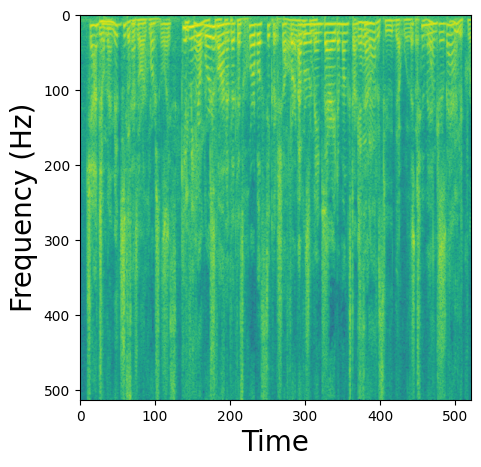

In [ ]:
spectrogram = spectrum.norm(dim=-1).pow(2)

plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

In [ ]:
def snr_mixer(clean, noise, snr):
    amp_noise = np.linalg.norm(clean) / 10**(snr / 20)

    noise_norm = (noise / np.linalg.norm(noise)) * amp_noise

    mix = clean + noise_norm

    return mix

def vad_merge(w, top_db):
    intervals = librosa.effects.split(w, top_db=top_db)
    temp = list()
    for s, e in intervals:
        temp.append(w[s:e])
    return np.concatenate(temp, axis=None)

def cut_audios(s1, s2, sec, sr):
    cut_len = sr * sec
    len1 = len(s1)
    len2 = len(s2)

    s1_cut = []
    s2_cut = []

    segment = 0
    while (segment + 1) * cut_len < len1 and (segment + 1) * cut_len < len2:
        s1_cut.append(s1[segment * cut_len:(segment + 1) * cut_len])
        s2_cut.append(s2[segment * cut_len:(segment + 1) * cut_len])

        segment += 1

    return s1_cut, s2_cut

def fix_length(s1, s2, min_or_max='max'):
    # Fix length
    if min_or_max == 'min':
        utt_len = np.minimum(len(s1), len(s2))
        s1 = s1[:utt_len]
        s2 = s2[:utt_len]
    else:  # max
        utt_len = np.maximum(len(s1), len(s2))
        s1 = np.append(s1, np.zeros(utt_len - len(s1)))
        s2 = np.append(s2, np.zeros(utt_len - len(s2)))
    return s1, s2

In [ ]:
def create_mix(idx, triplet, snr_levels, out_dir, test=False, sr=16000, **kwargs):
    trim_db, vad_db = kwargs["trim_db"], kwargs["vad_db"]
    audioLen = kwargs["audioLen"]

    s1_path = triplet["target"]
    s2_path = triplet["noise"]
    ref_path = triplet["reference"]
    target_id = triplet["target_id"]
    noise_id = triplet["noise_id"]

    s1, _ = sf.read(os.path.join('', s1_path))
    s2, _ = sf.read(os.path.join('', s2_path))
    ref, _ = sf.read(os.path.join('', ref_path))

    meter = pyln.Meter(sr) # create BS.1770 meter

    louds1 = meter.integrated_loudness(s1)
    louds2 = meter.integrated_loudness(s2)
    loudsRef = meter.integrated_loudness(ref)

    s1Norm = pyln.normalize.loudness(s1, louds1, -29)
    s2Norm = pyln.normalize.loudness(s2, louds2, -29)
    refNorm = pyln.normalize.loudness(ref, loudsRef, -23.0)

    amp_s1 = np.max(np.abs(s1Norm))
    amp_s2 = np.max(np.abs(s2Norm))
    amp_ref = np.max(np.abs(refNorm))

    if amp_s1 == 0 or amp_s2 == 0 or amp_ref == 0:
        return

    if trim_db:
        ref, _ = librosa.effects.trim(refNorm, top_db=trim_db)
        s1, _ = librosa.effects.trim(s1Norm, top_db=trim_db)
        s2, _ = librosa.effects.trim(s2Norm, top_db=trim_db)

    if len(ref) < sr:
        return

    path_mix = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-mixed.wav")
    path_target = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-target.wav")
    path_ref = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-ref.wav")

    snr = np.random.choice(snr_levels, 1).item()

    if not test:
        s1, s2 = vad_merge(s1, vad_db), vad_merge(s2, vad_db)
        s1_cut, s2_cut = cut_audios(s1, s2, audioLen, sr)

        for i in range(len(s1_cut)):
            mix = snr_mixer(s1_cut[i], s2_cut[i], snr)

            louds1 = meter.integrated_loudness(s1_cut[i])
            s1_cut[i] = pyln.normalize.loudness(s1_cut[i], louds1, -23.0)
            loudMix = meter.integrated_loudness(mix)
            mix = pyln.normalize.loudness(mix, loudMix, -23.0)

            path_mix_i = path_mix.replace("-mixed.wav", f"_{i}-mixed.wav")
            path_target_i = path_target.replace("-target.wav", f"_{i}-target.wav")
            path_ref_i = path_ref.replace("-ref.wav", f"_{i}-ref.wav")
            sf.write(path_mix_i, mix, sr)
            sf.write(path_target_i, s1_cut[i], sr)
            sf.write(path_ref_i, ref, sr)
    else:
        s1, s2 = fix_length(s1, s2, 'max')
        mix = snr_mixer(s1, s2, snr)
        louds1 = meter.integrated_loudness(s1)
        s1 = pyln.normalize.loudness(s1, louds1, -23.0)

        loudMix = meter.integrated_loudness(mix)
        mix = pyln.normalize.loudness(mix, loudMix, -23.0)

        sf.write(path_mix, mix, sr)
        sf.write(path_target, s1, sr)
        sf.write(path_ref, ref, sr)

In [ ]:
class LibriSpeechSpeakerFiles:
    def __init__(self, speaker_id, audios_dir, audioTemplate="*-norm.wav"):
        self.id = speaker_id
        self.files = []
        self.audioTemplate=audioTemplate
        self.files = self.find_files_by_worker(audios_dir)

    def find_files_by_worker(self, audios_dir):
        speakerDir = os.path.join(audios_dir,self.id) #it is a string
        chapterDirs = os.scandir(speakerDir)
        files=[]
        for chapterDir in chapterDirs:
            files = files + [file for file in glob(os.path.join(speakerDir,chapterDir.name)+"/"+self.audioTemplate)]
        return files

In [ ]:
class MixtureGenerator:
    def __init__(self, speakers_files, out_folder, nfiles=5000, test=False, randomState=42):
        self.speakers_files = speakers_files # list of SpeakerFiles for every speaker_id
        self.nfiles = nfiles
        self.randomState = randomState
        self.out_folder = out_folder
        self.test = test
        random.seed(self.randomState)
        if not os.path.exists(self.out_folder):
            os.makedirs(self.out_folder)

    def generate_triplets(self):
        i = 0
        all_triplets = {"reference": [], "target": [], "noise": [], "target_id": [], "noise_id": []}
        while i < self.nfiles:
            spk1, spk2 = random.sample(self.speakers_files, 2)

            if len(spk1.files) < 2 or len(spk2.files) < 2:
                continue

            target, reference = random.sample(spk1.files, 2)
            noise = random.choice(spk2.files)
            all_triplets["reference"].append(reference)
            all_triplets["target"].append(target)
            all_triplets["noise"].append(noise)
            all_triplets["target_id"].append(spk1.id)
            all_triplets["noise_id"].append(spk2.id)
            i += 1

        return all_triplets

    def triplet_generator(self, target_speaker, noise_speaker, number_of_triplets):
        max_num_triplets = min(len(target_speaker.files), len(noise_speaker.files))
        number_of_triplets = min(max_num_triplets, number_of_triplets)

        target_samples = random.sample(target_speaker.files, k=number_of_triplets)
        reference_samples = random.sample(target_speaker.files, k=number_of_triplets)
        noise_samples = random.sample(noise_speaker.files, k=number_of_triplets)

        triplets = {"reference": [], "target": [], "noise": [],
                    "target_id": [target_speaker.id] * number_of_triplets, "noise_id": [noise_speaker.id] * number_of_triplets}
        triplets["target"] += target_samples
        triplets["reference"] += reference_samples
        triplets["noise"] += noise_samples

        return triplets

    def generate_mixes(self, snr_levels=[0], num_workers=10, update_steps=10, **kwargs):

        triplets = self.generate_triplets()

        with ProcessPoolExecutor(max_workers=num_workers) as pool:
            futures = []

            for i in range(self.nfiles):
                triplet = {"reference": triplets["reference"][i],
                           "target": triplets["target"][i],
                           "noise": triplets["noise"][i],
                           "target_id": triplets["target_id"][i],
                           "noise_id": triplets["noise_id"][i]}

                futures.append(pool.submit(create_mix, i, triplet,
                                           snr_levels, self.out_folder,
                                           test=self.test, **kwargs))

            for i, future in enumerate(futures):
                future.result()
                if (i + 1) % max(self.nfiles // update_steps, 1) == 0:
                    print(f"Files Processed | {i + 1} out of {self.nfiles}")

In [ ]:
path_train = '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/'
path_val = '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/'

path_mixtures_train = '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train'
path_mixtures_val = '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_val'

speakersTrain = [el.name for el in os.scandir(path_train)]
speakersVal = [el.name for el in os.scandir(path_val)]

speakers_files_train = [LibriSpeechSpeakerFiles(i, path_train, audioTemplate="*.flac") for i in speakersTrain]
speakers_files_val = [LibriSpeechSpeakerFiles(i, path_val, audioTemplate="*.flac") for i in speakersVal]

mixer_train = MixtureGenerator(speakers_files_train,
                                path_mixtures_train,
                                nfiles=100,
                                test=False)

mixer_val = MixtureGenerator(speakers_files_val,
                                path_mixtures_val,
                                nfiles=100,
                                test=True)

In [ ]:
mixer_train.generate_mixes(snr_levels=[-5, 5],
                           num_workers=2,
                           update_steps=100,
                           trim_db=20,
                           vad_db=20,
                           audioLen=3)

Files Processed | 1 out of 100
Files Processed | 2 out of 100
Files Processed | 3 out of 100
Files Processed | 4 out of 100
Files Processed | 5 out of 100
Files Processed | 6 out of 100
Files Processed | 7 out of 100
Files Processed | 8 out of 100
Files Processed | 9 out of 100
Files Processed | 10 out of 100
Files Processed | 11 out of 100
Files Processed | 12 out of 100
Files Processed | 13 out of 100
Files Processed | 14 out of 100
Files Processed | 15 out of 100
Files Processed | 16 out of 100
Files Processed | 17 out of 100
Files Processed | 18 out of 100
Files Processed | 19 out of 100
Files Processed | 20 out of 100
Files Processed | 21 out of 100
Files Processed | 22 out of 100
Files Processed | 23 out of 100
Files Processed | 24 out of 100
Files Processed | 25 out of 100
Files Processed | 26 out of 100
Files Processed | 27 out of 100
Files Processed | 28 out of 100
Files Processed | 29 out of 100
Files Processed | 30 out of 100
Files Processed | 31 out of 100
Files Processed |

In [ ]:
mixer_val.generate_mixes(snr_levels=[0],
                           num_workers=2,
                           update_steps=100,
                           trim_db=None,
                           vad_db=20,
                           audioLen=3)

Files Processed | 1 out of 100
Files Processed | 2 out of 100
Files Processed | 3 out of 100
Files Processed | 4 out of 100
Files Processed | 5 out of 100
Files Processed | 6 out of 100
Files Processed | 7 out of 100
Files Processed | 8 out of 100
Files Processed | 9 out of 100
Files Processed | 10 out of 100
Files Processed | 11 out of 100
Files Processed | 12 out of 100
Files Processed | 13 out of 100
Files Processed | 14 out of 100
Files Processed | 15 out of 100
Files Processed | 16 out of 100
Files Processed | 17 out of 100
Files Processed | 18 out of 100
Files Processed | 19 out of 100
Files Processed | 20 out of 100
Files Processed | 21 out of 100
Files Processed | 22 out of 100
Files Processed | 23 out of 100
Files Processed | 24 out of 100
Files Processed | 25 out of 100
Files Processed | 26 out of 100
Files Processed | 27 out of 100
Files Processed | 28 out of 100
Files Processed | 29 out of 100
Files Processed | 30 out of 100
Files Processed | 31 out of 100
Files Processed |

In [ ]:
train_mixes = os.listdir(path_mixtures_train)
val_mixes = os.listdir(path_mixtures_val)

In [ ]:
train_mixes[:100]

['2902_422_000078_2-ref.wav',
 '2086_1993_000044_0-target.wav',
 '2902_422_000078_3-mixed.wav',
 '5536_7976_000079_0-mixed.wav',
 '5338_652_000057_1-target.wav',
 '5536_3853_000093_0-mixed.wav',
 '422_1272_000026_0-ref.wav',
 '8842_1272_000054_0-ref.wav',
 '174_3000_000064_1-target.wav',
 '2902_1988_000005_1-mixed.wav',
 '777_174_000080_0-ref.wav',
 '174_3000_000064_2-mixed.wav',
 '6295_5895_000089_0-target.wav',
 '8842_6319_000025_1-mixed.wav',
 '6313_3170_000023_0-mixed.wav',
 '6319_5536_000062_0-target.wav',
 '5536_3853_000093_1-target.wav',
 '174_3000_000064_1-mixed.wav',
 '422_5338_000021_0-target.wav',
 '6241_2078_000045_0-target.wav',
 '2902_422_000078_3-target.wav',
 '174_3170_000019_1-mixed.wav',
 '652_5338_000051_0-ref.wav',
 '6241_7850_000083_0-mixed.wav',
 '5536_3000_000017_0-target.wav',
 '2428_3576_000075_0-target.wav',
 '6313_2277_000029_0-ref.wav',
 '7850_1462_000050_0-mixed.wav',
 '1673_5895_000061_0-ref.wav',
 '3081_8297_000013_0-target.wav',
 '3081_8297_000013_0-ref.

In [ ]:
ref_train = sorted(glob(os.path.join(path_mixtures_train, '*-ref.wav')))
mix_train = sorted(glob(os.path.join(path_mixtures_train, '*-mixed.wav')))
target_train = sorted(glob(os.path.join(path_mixtures_train, '*-target.wav')))

In [ ]:
mix_train[:10]

['/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1272_84_000066_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1462_3536_000077_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1462_6313_000042_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_422_000099_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5694_000097_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5895_000061_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5895_000061_1-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/174_3000_000064_0-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/174_3000_000064_1-mixed.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/174_30

In [ ]:
target_train[:10]

['/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1272_84_000066_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1462_3536_000077_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1462_6313_000042_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_422_000099_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5694_000097_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5895_000061_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/1673_5895_000061_1-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/174_3000_000064_0-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_train/174_3000_000064_1-target.wav',
 '/home/ubuntu/ss_project/data/datasets/librispeech/dev-clean/mix_tra

In [ ]:
ref, mix, target = ref_train[0], mix_train[0], target_train[0]

In [ ]:
from IPython import display

display.display(display.Audio(ref, rate=16000))
display.display(display.Audio(mix, rate=16000))
display.display(display.Audio(target, rate=16000))